In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re
from datetime import datetime

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [3]:
path_orbit = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.18.44.00.711409.parquet')
bpm_orbit = ak.Array(ak.from_parquet(path_orbit), with_name='BPMCollection')

In [81]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [82]:
tt = line.get_table()
tw = line.twiss()

env = line.env
s_bph = line.get_s_position('bph.41607')
s_a_aper = line.get_s_position('bph.41607.a_aper')
s_b_aper = line.get_s_position('bph.41607.b_aper')
elem = line['bph.41607'].copy()
aper = line['bph.41607.a_aper'].copy()

line.remove(tt.rows['bph.41607.*'].name)

env.elements['bph.41608'] = elem
env.elements['bph.41608.a_aper'] = aper
env.elements['bph.41608.b_aper'] = aper.copy()

line.insert(env.place('bph.41608', at=s_bph, anchor='start'), s_tol=1e-6)
line.insert([env.place('bph.41608.a_aper', at=s_a_aper),
            env.place('bph.41608.b_aper', at=s_b_aper)], s_tol=1e-6)

Slicing line:   0%|          | 0/32536 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/32536 [00:00<?, ?it/s]

In [66]:
mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in bpm_orbit.bpms_hor])
s_positions_bpms = np.array([line.get_s_position(f'{bpm}') for bpm in bpm_orbit.bpms_hor])

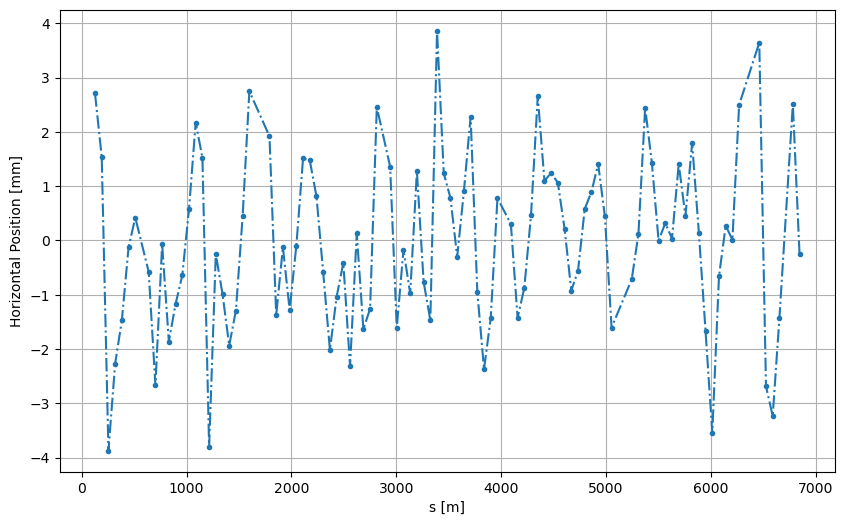

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], ak.mean(bpm_orbit.hor_turn_position[mask_bpm], axis=1), '.-.', label='Horizontal')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()

In [68]:
mean_orbit = ak.mean(bpm_orbit.hor_turn_position[mask_bpm], axis=1)

In [69]:
def build_response_matrix(tw, monitor_names, corrector_names, plane=None):

    assert plane in ['x', 'y']

    # Build response matrix
    indices_monitors = tw.rows.indices[monitor_names]
    indices_correctors = tw.rows.indices[corrector_names]
    bet_monitors = tw['bet' + plane][indices_monitors]
    bet_correctors = tw['bet' + plane][indices_correctors]

    mu_monitor = tw['mu' + plane][indices_monitors]
    mux_correctors = tw['mu' + plane][indices_correctors]

    n_monitors = len(monitor_names)
    n_correctors = len(corrector_names)

    bet_prod = np.atleast_2d(bet_monitors).T @ np.atleast_2d(bet_correctors)
    mu_diff = (np.tile(mu_monitor, (n_correctors, 1)).T
                        - np.tile(mux_correctors, (n_monitors, 1)))

    # Slide 28
    # https://indico.cern.ch/event/1328128/contributions/5589794/attachments/2786478/4858384/linearimperfections_2024.pdf
    tune = tw['q' + plane]
    response_matrix = (np.sqrt(bet_prod) / 2 / np.sin(np.pi * tune)
                            * np.cos(np.pi * tune - 2*np.pi*np.abs(mu_diff)))

    return response_matrix

# """
#     Construct response matrix
#     """
#     response_matrix_H = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_H, 
#         corrector_names=errors_H, 
#         plane='x')
#     response_matrix_V = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_V, 
#         corrector_names=errors_V, 
#         plane='y')
    

#     """
#     Calculate necessary errors
#     """
#     U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
#     threshold_H = 1e-3 * np.max(sigma_H)
#     sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
#     M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
#     k_H = M_pseudo_inv_H @ target_val_H

#     U_V, sigma_V, VT_V = np.linalg.svd(response_matrix_V, full_matrices=False)
#     threshold_V = 1e-4 * np.max(sigma_V)
#     sigma_inv_V = np.array([1/s if s > threshold_V else 0 for s in sigma_V])
#     M_pseudo_inv_V = VT_V.T @ np.diag(sigma_inv_V) @ U_V.T
#     k_V = M_pseudo_inv_V @ target_val_V


In [83]:
error_locs_H = []
for i in range(len(line.element_names)):
    name = line.element_names[i]
    if name.startswith("qf."):
        error_locs_H.append(name)

In [84]:
line.discard_tracker()

for i in range(len(error_locs_H)):
    print("Adding H error", i+1, "out of", len(error_locs_H))

    error_loc_name = re.split(r"[._]", error_locs_H[i])
    knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
    errname = "errH_" + error_loc_name[0] + error_loc_name[1]

    line.vars[knl_name] = 0.0

    curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
    curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
    line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

    line.element_refs[errname].knl[0] = line.vars[knl_name]

Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H error 34 out of 102
Adding H error 35 out o

In [85]:
line.build_tracker()

In [86]:
errors_H = []
for name in line.element_names:
    if "errH" in name:
        errors_H.append(name)

In [87]:
tw_ref = line.twiss()

In [88]:
response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{name}' for name in bpm_orbit.bpms_hor[mask_bpm]], 
        corrector_names=errors_H, 
        plane='x')

In [89]:
U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
threshold_H = 1e-3 * np.max(sigma_H)
threshold_H = 3e-3 * np.max(sigma_H)
sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
k_H = M_pseudo_inv_H @ ak.to_numpy(mean_orbit*1e-3)

In [90]:
vary_H = []
for var_name in line.vars.keys():
    if "knl_err" in var_name:
        vary_H.append(var_name)

In [91]:
for i in range(len(vary_H)):
    line.vv[vary_H[i]] = k_H[i] * -1

In [92]:
tw = line.twiss()

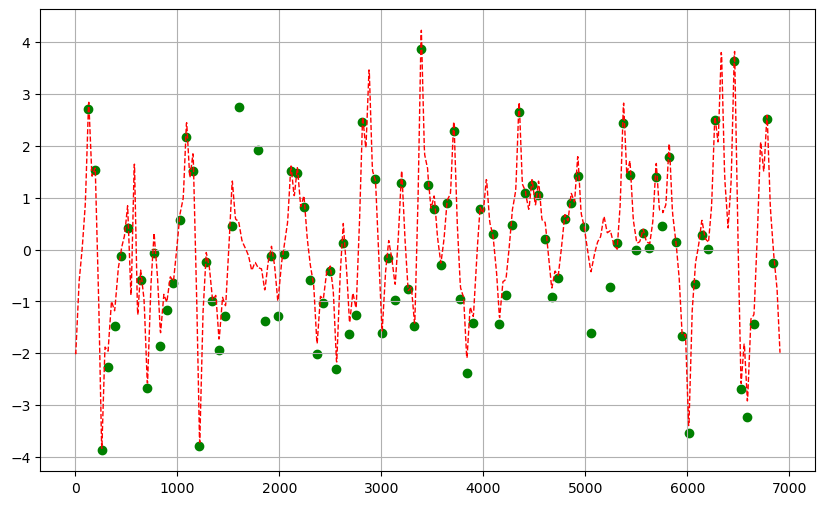

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms[mask_bpm], mean_orbit, color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.grid()

In [94]:
line.to_json('../../injection_lines/sps_orbit_md_20250616_v3.json')

# Comparing orbit with potential bottlenecks

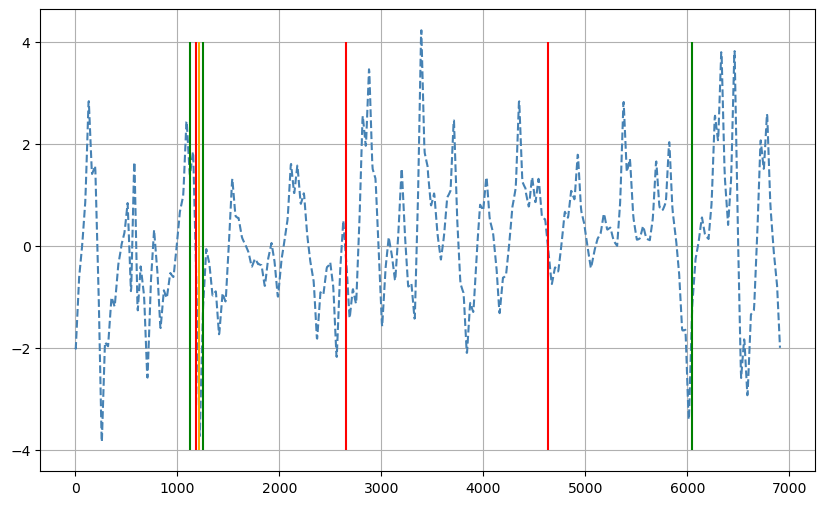

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(tw.s, tw.x * 1e3, '--', lw=1.5, color='steelblue', label='Twiss')
ax.vlines(line.get_s_position('qd.50110'), -4, 4, colors='red')
ax.vlines(line.get_s_position('qd.31110'), -4, 4, colors='red')
ax.vlines(line.get_s_position('qd.20110'), -4, 4, colors='red')

ax.vlines(line.get_s_position('qd.13510'), -4, 4, colors='green')
ax.vlines(line.get_s_position('qd.20310'), -4, 4, colors='green')
ax.vlines(line.get_s_position('qd.60910'), -4, 4, colors='green')

ax.vlines(line.get_s_position('qf.20210'), -4, 4, colors='orange')
ax.grid()
# ax.set_xlim(1000,1500)

In [119]:
tt = line.get_table()

In [121]:
tt.rows['qd.20110':'qd.20310'].show()

name                              s element_type        isthick isreplica parent_name        ...
qd.20110                    1183.91 Quadrupole             True     False None              
drift_322..0                   1187 DriftSlice             True     False drift_322         
veqd.20110.b_aper           1187.17 LimitEllipse          False     False None              
drift_322..1                1187.17 DriftSlice             True     False drift_322         
vebb.20130.a_aper           1187.17 LimitRect             False     False None              
drift_322..2                1187.17 DriftSlice             True     False drift_322         
mbb.20130_entry             1187.35 Marker                False     False None              
mbb.20130..entry_map        1187.35 ThinSliceRBendEntry   False     False mbb.20130         
mbb.20130..0_aper2          1187.35 LimitRect             False     False None              
mbb.20130..0                1187.35 ThickSliceRBend        True   